In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path('dataset2/train')
train_filepaths = list(train_dir.glob(r'*/*'))

test_dir = Path('dataset2/test')
test_filepaths = list(test_dir.glob(r'*/*'))

val_dir = Path('dataset2/validation')
val_filepaths = list(test_dir.glob(r'*/*'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [3]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3300

Number of different labels: 33

Labels: ['potato' 'beetroot' 'spinach' 'lettuce' 'grapes' 'soy beans' 'garlic'
 'banana' 'cauliflower' 'raddish' 'turnip' 'ginger' 'watermelon'
 'pineapple' 'orange' 'pear' 'peas' 'bell pepper' 'apple' 'cabbage'
 'mango' 'chilli pepper' 'carrot' 'pomegranate' 'jalepeno' 'corn' 'onion'
 'sweetpotato' 'cucumber' 'kiwi' 'lemon' 'tomato' 'eggplant']


In [4]:
train_df.head(5)

,Filepath,Label
0,dataset2\train\potato\Image_72.jpg,potato
1,dataset2\train\beetroot\Image_27.jpg,beetroot
2,dataset2\train\spinach\Image_71.JPG,spinach
3,dataset2\train\lettuce\Image_93.jpg,lettuce
4,dataset2\train\grapes\Image_38.jpg,grapes


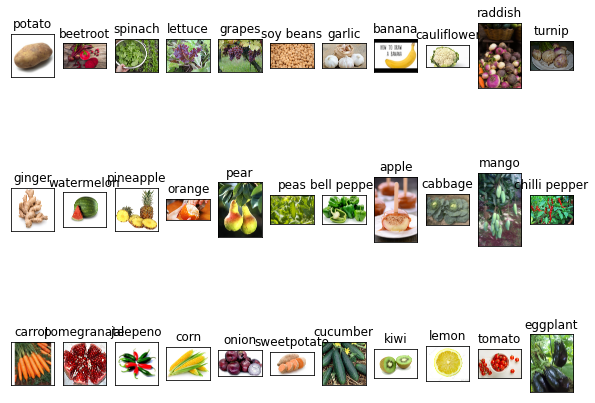

In [5]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3300 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.


In [15]:
pt_hyperparameters = ['avg', 'max']

adam_hyperparameters = [0.0001, 0.001, 0.01]

In [17]:
best_score = 0
for p in pt_hyperparameters :
    
    pretrained_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=p
    )
    pretrained_model.trainable = False
    
    for l in adam_hyperparameters:
        print('=============================')
        print('POOLING: ' + p)
        print('LEARNING RATE: ' + str(l))
        inputs = pretrained_model.input

        x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
        outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=l),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_images,
            validation_data=val_images,
            batch_size = 32,
            epochs=20,
        )
        
        val_acc = history.history['val_accuracy'][-1]
        
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'p' : p, 'l' : l}

print("Best accuracy: ", best_score)
print("Best grid: ", best_params)

POOLING: avg
LEARNING RATE: 0.0001
Epoch 1/20
 13/104 [==>...........................] - ETA: 2:19 - loss: 3.8853 - accuracy: 0.0361


KeyboardInterrupt



In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=2,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=2,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/2
104/104 [==============================] - 169s 2s/step - loss: 1.7495 - accuracy: 0.5397 - val_loss: 1.0415 - val_accuracy: 0.7091
Epoch 2/2
 82/104 [======================>.......] - ETA: 31s - loss: 0.7208 - accuracy: 0.7947

In [22]:
val_acc = history.history['val_accuracy'][-1]
print(val_acc)

0.7030302882194519


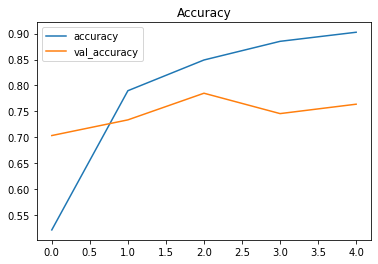

In [9]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

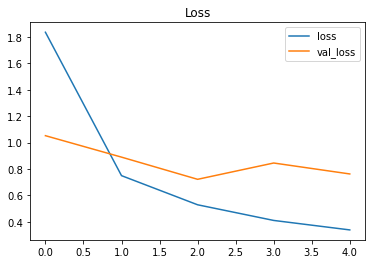

In [10]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [11]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

 6/11 [===============>..............] - ETA: 4s

C:\Users\JAMES SY\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 11s 860ms/step


In [12]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 76.36%


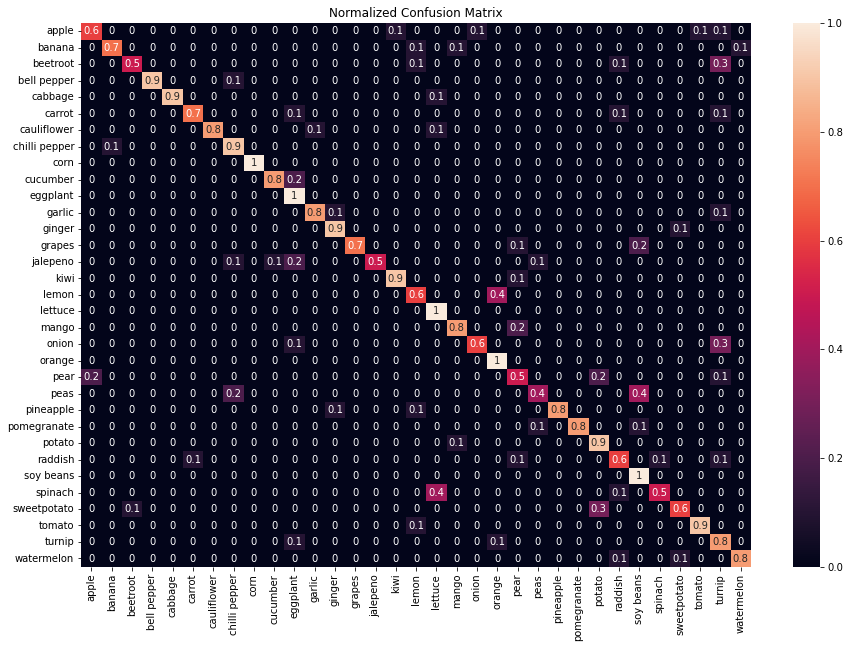

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

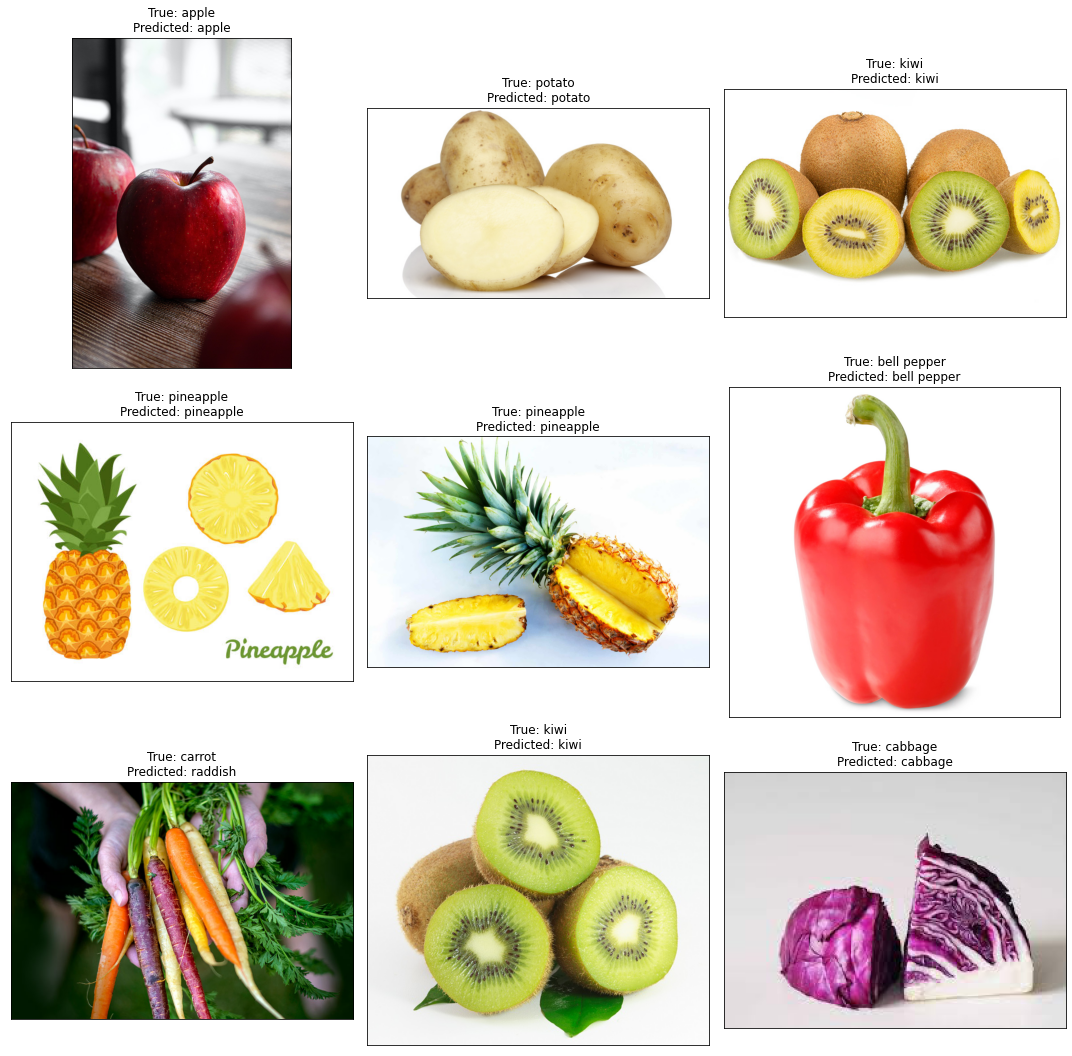

In [14]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()